# Download the Data

In [22]:
import pandas as pd

df = pd.read_csv("data/insurance.csv")

In [23]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- bmi = Body mass index
- charges: Individual medical costs billed by health insurance

In [25]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


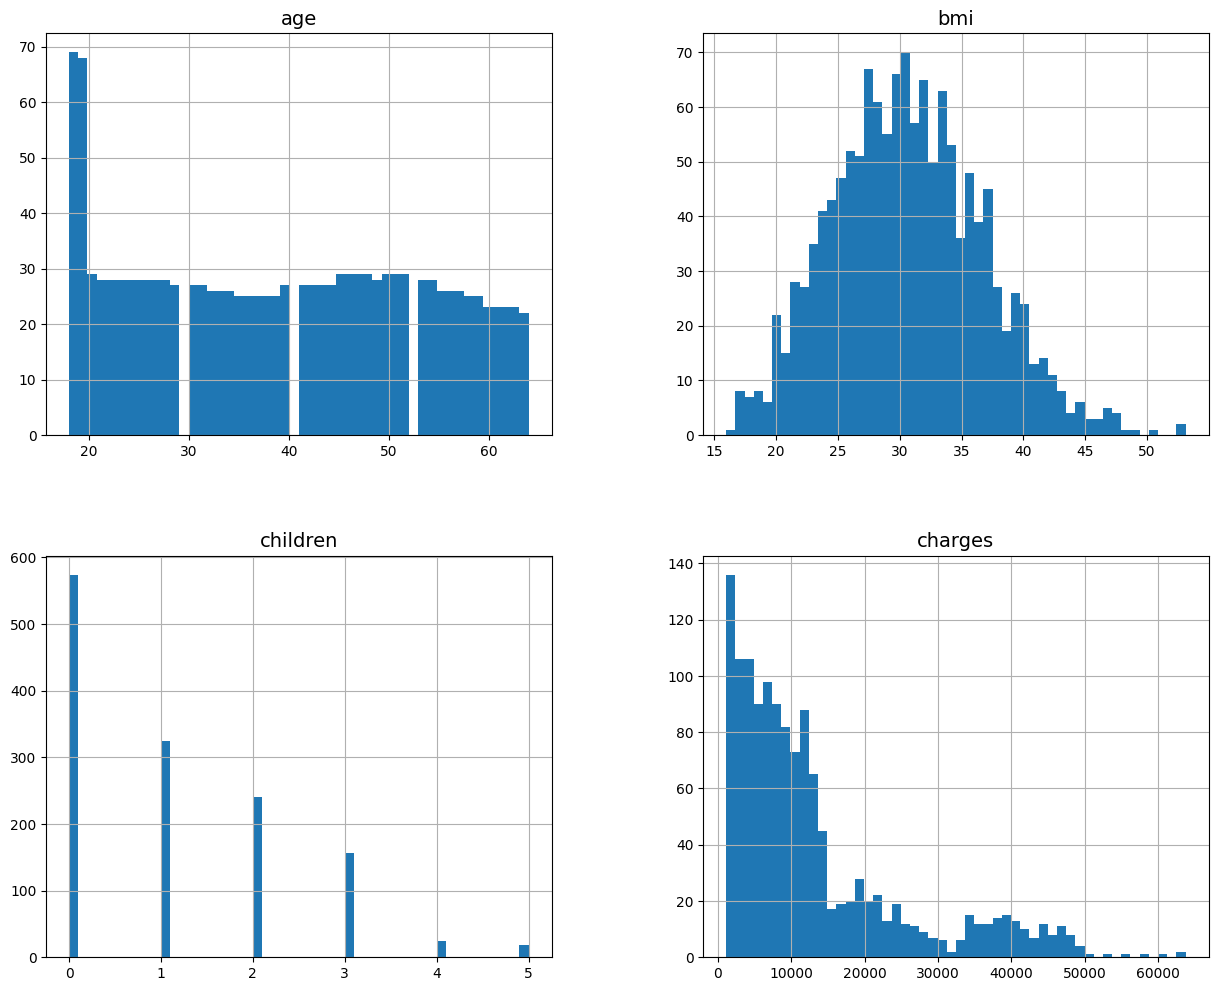

In [26]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15,12))
plt.show()

# Create a Test Set

In [27]:
import numpy as np

df["charges_cat"] = pd.cut(df["charges"],
                               bins = [1120, 4740, 9382, 16639, 30000, np.inf],
                               labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'])

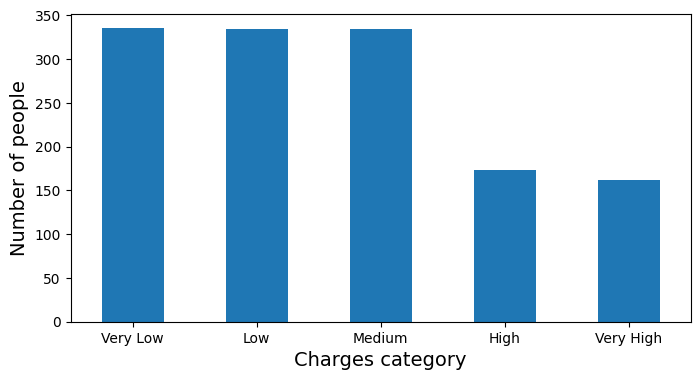

In [28]:
plt.figure(figsize=(8, 4))

df["charges_cat"].value_counts().sort_index().plot.bar(rot=0, grid=False)
plt.xlabel("Charges category")
plt.ylabel("Number of people")

plt.show()

In [29]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, stratify=df['charges_cat'], test_size=0.2, random_state=42)

In [30]:
def income_cat_proportions(data):
    return data["charges_cat"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(df),
    "Stratified %": income_cat_proportions(test_set),
}).sort_index()

(compare_props * 100).round(2)

,Overall %,Stratified %
charges_cat,,
Very Low,25.04,25.00
Low,24.96,25.00
Medium,24.96,25.00
High,12.93,13.06
Very High,12.11,11.94


In [31]:
for set_ in (train_set, test_set):
    set_.drop("charges_cat", axis=1, inplace=True)

# Discover and Visualize the Data

In [32]:
insurance = train_set.copy()

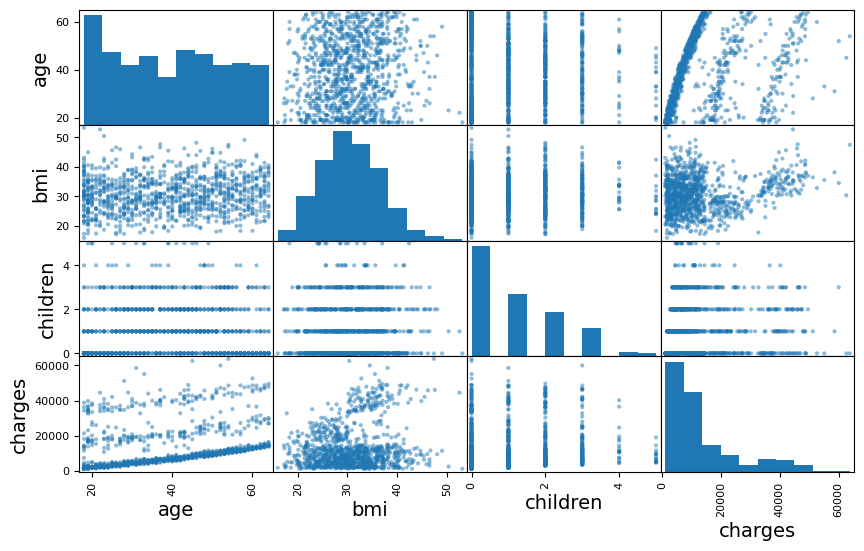

In [33]:
from pandas.plotting import scatter_matrix

numerical_columns = insurance.select_dtypes(include=['int64', 'float']).columns
scatter_matrix(insurance[numerical_columns], figsize=(10, 6))

plt.show()

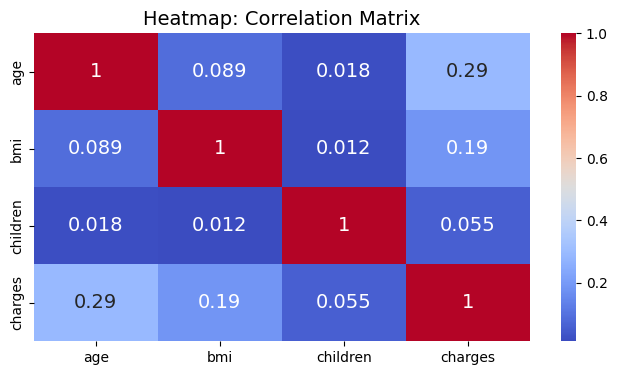

In [34]:
import seaborn as sns

correlation_matrix = insurance[numerical_columns].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')
plt.show()

# Prepare the Data

In [35]:
insurance = train_set.drop("charges", axis=1)
insurance_label = train_set["charges"].copy()

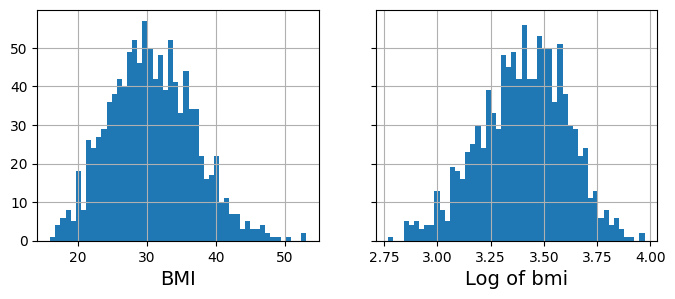

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
insurance["bmi"].hist(ax=axs[0], bins=50)
insurance["bmi"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("BMI")
axs[1].set_xlabel("Log of bmi")

plt.show()

In [37]:
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [40]:
insurance['region'].value_counts()

region
southeast    294
northeast    260
southwest    259
northwest    257
Name: count, dtype: int64

## Transformation Pipeline

In [41]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['sex', 'smoker', 'region']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

preprocessing = ColumnTransformer([
        ("log", log_pipeline, ["age", "bmi"]),
        ("cat", cat_pipeline, cat_attribs),
    ], remainder='passthrough')

In [54]:
insurance_prepared = preprocessing.fit_transform(insurance)
insurance_prepared.shape

(1070, 11)

In [55]:
insurance.shape

(1070, 6)

In [56]:
preprocessing.get_feature_names_out()

array(['log__age', 'log__bmi', 'cat__sex_female', 'cat__sex_male',
       'cat__smoker_no', 'cat__smoker_yes', 'cat__region_northeast',
       'cat__region_northwest', 'cat__region_southeast',
       'cat__region_southwest', 'remainder__children'], dtype=object)

# Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())

In [58]:
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(lin_rmses).describe()

count      10.000000
mean     6145.983728
std       683.714780
min      5243.014235
25%      5594.074208
50%      6106.548224
75%      6568.160699
max      7280.824471
dtype: float64

In [89]:
relative_rmse_lin_reg = lin_rmses.mean() / insurance_label.mean()
relative_rmse_lin_reg.round(2)

0.46

In [62]:
lin_reg.fit(insurance, insurance_label)
y_pred = lin_reg.predict(insurance)

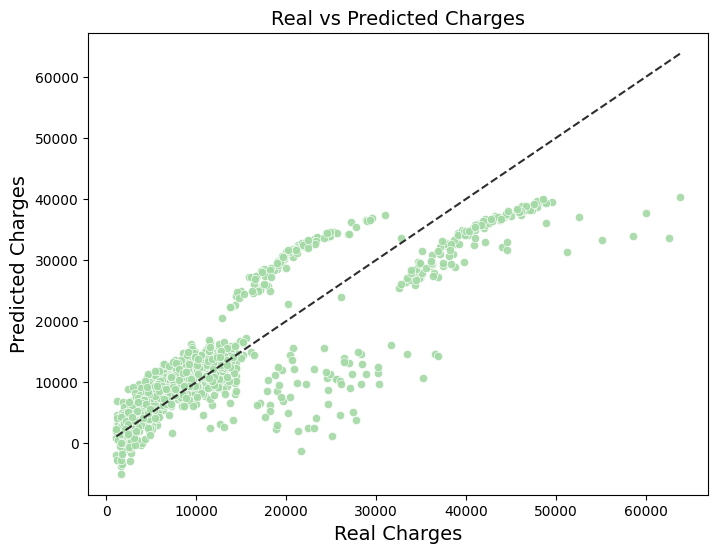

In [83]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=insurance_label, y=y_pred, color='#A3D9A5', alpha=0.9)
sns.lineplot(x=[min(insurance_label), max(insurance_label)], 
             y=[min(insurance_label), max(insurance_label)], 
             color='#2E2E2E', linestyle='--')
plt.xlabel('Real Charges')
plt.ylabel('Predicted Charges')
plt.title('Real vs Predicted Charges')
plt.show()

In [87]:
from sklearn.linear_model import SGDRegressor

sgd_reg = make_pipeline(preprocessing, SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)) # penalty=None means no regularization, as we want a linear model. Scikit Learn uses l2 regularization by default.

In [88]:
from sklearn.model_selection import cross_val_score

sgd_rmses = -cross_val_score(sgd_reg, insurance, insurance_label,
                              scoring="neg_root_mean_squared_error", cv=10)

pd.Series(sgd_rmses).describe()

count      10.000000
mean     6147.248688
std       683.220228
min      5243.689535
25%      5597.801582
50%      6109.252606
75%      6573.330795
max      7281.980784
dtype: float64

In [90]:
relative_rmse_sgd_lin = lin_rmses.mean() / insurance_label.mean()
relative_rmse_sgd_lin.round(2)

0.46

# Polynomial Regression